# Benchmarking Environment for Liar's Dice Game
(AA228 Final Project)

In [1]:
%load_ext autoreload
%autoreload 2
from src.game import LiarsDiceGame
from config import *
import numpy as np
import matplotlib.pyplot as plt

## Testing

In [12]:
winner = LiarsDiceGame.game("wildcard_conservative", "random", save_json=True)
print(f"Winner is Player P{winner}")

Game over! Winner: P0. Game history saved to data/game_20251124_172813_3b28fe.json
Winner is Player P0


## Settings

In [3]:
N_GAMES = 1000  # Number of games to simulate
latex_figsize = (6, 2)  # Figure size for LaTeX documents
latex_fontsize = 10  # Font size for LaTeX documents
save_path = "figures/"  # Directory to save figures

## Random vs 3 Random

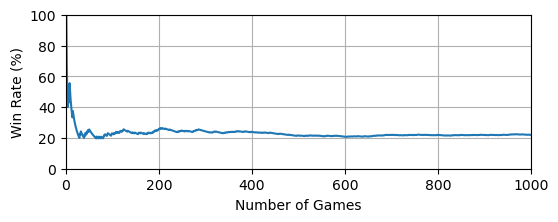

In [ ]:
# config
player = "rand"
enemies = ["rand", "rand", "rand"]

# initialize win_rate
win_rate = np.zeros(N_GAMES)

for i in range(N_GAMES):
    winner = LiarsDiceGame.game(player, *enemies, save_json=False, dir=None)
    if i == 0:
        win_rate[i] = 1 if winner == 0 else 0
    else:
        if winner == 0:
            win_rate[i] = (win_rate[i-1] * i + 1) / (i + 1)
        else:
            win_rate[i] = (win_rate[i-1] * i) / (i + 1)

# plot results
plt.figure(figsize=latex_figsize)
plt.plot(win_rate * 100)
plt.xlabel("Number of Games", fontsize=latex_fontsize)
plt.ylabel("Win Rate (%)", fontsize=latex_fontsize)
plt.xlim(0, N_GAMES)
plt.ylim(0, 100)
plt.grid()

## Risky vs 3 Random

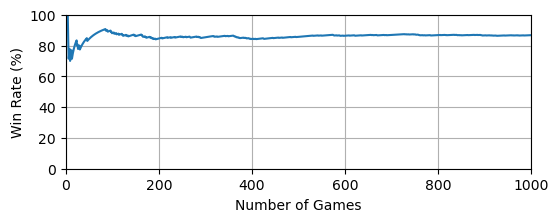

In [5]:
# config
player = "risky"
enemies = ["rand", "rand", "rand"]

# initialize win_rate
win_rate = np.zeros(N_GAMES)

for i in range(N_GAMES):
    winner = LiarsDiceGame.game(player, *enemies, save_json=False, dir=None)
    if i == 0:
        win_rate[i] = 1 if winner == 0 else 0
    else:
        if winner == 0:
            win_rate[i] = (win_rate[i-1] * i + 1) / (i + 1)
        else:
            win_rate[i] = (win_rate[i-1] * i) / (i + 1)

# plot results
plt.figure(figsize=latex_figsize)
plt.plot(win_rate * 100)
plt.xlabel("Number of Games", fontsize=latex_fontsize)
plt.ylabel("Win Rate (%)", fontsize=latex_fontsize)
plt.xlim(0, N_GAMES)
plt.ylim(0, 100)
plt.grid()

## Risk-Averse vs 3 Random

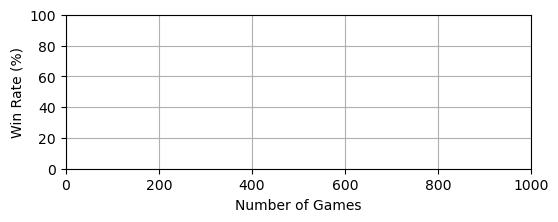

In [6]:
# config
player = "risk-averse"
enemies = ["rand", "rand", "rand"]

# initialize win_rate
win_rate = np.zeros(N_GAMES)

for i in range(N_GAMES):
    winner = LiarsDiceGame.game(player, *enemies, save_json=False, dir=None)
    if i == 0:
        win_rate[i] = 1 if winner == 0 else 0
    else:
        if winner == 0:
            win_rate[i] = (win_rate[i-1] * i + 1) / (i + 1)
        else:
            win_rate[i] = (win_rate[i-1] * i) / (i + 1)

# plot results
plt.figure(figsize=latex_figsize)
plt.plot(win_rate * 100)
plt.xlabel("Number of Games", fontsize=latex_fontsize)
plt.ylabel("Win Rate (%)", fontsize=latex_fontsize)
plt.xlim(0, N_GAMES)
plt.ylim(0, 100)
plt.grid()

## Risk-Averse vs 3 Risky

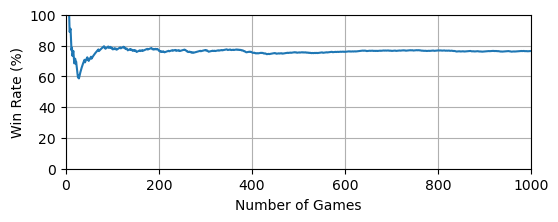

In [7]:
# config
player = "risk-averse"
enemies = [ "risky", "risky", "risky"]

# initialize win_rate
win_rate = np.zeros(N_GAMES)

for i in range(N_GAMES):
    winner = LiarsDiceGame.game(player, *enemies, save_json=False, dir=None)
    if i == 0:
        win_rate[i] = 1 if winner == 0 else 0
    else:
        if winner == 0:
            win_rate[i] = (win_rate[i-1] * i + 1) / (i + 1)
        else:
            win_rate[i] = (win_rate[i-1] * i) / (i + 1)

# plot results
plt.figure(figsize=latex_figsize)
plt.plot(win_rate * 100)
plt.xlabel("Number of Games", fontsize=latex_fontsize)
plt.ylabel("Win Rate (%)", fontsize=latex_fontsize)
plt.xlim(0, N_GAMES)
plt.ylim(0, 100)
plt.grid()

## Own Conservative vs 3 WiLDCARD conservative

0.591


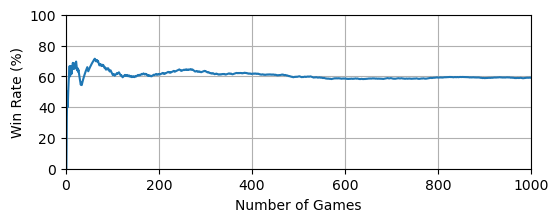

In [8]:
# config
player = "conservative"
enemies = ["wildcard conservative", "wildcard conservative", "wildcard conservative"]

# initialize win_rate
win_rate = np.zeros(N_GAMES)

for i in range(N_GAMES):
    winner = LiarsDiceGame.game(player, *enemies, save_json=False, dir=None)
    if i == 0:
        win_rate[i] = 1 if winner == 0 else 0
    else:
        if winner == 0:
            win_rate[i] = (win_rate[i-1] * i + 1) / (i + 1)
        else:
            win_rate[i] = (win_rate[i-1] * i) / (i + 1)

print(win_rate[-1])
# plot results
plt.figure(figsize=latex_figsize)
plt.plot(win_rate * 100)
plt.xlabel("Number of Games", fontsize=latex_fontsize)
plt.ylabel("Win Rate (%)", fontsize=latex_fontsize)
plt.xlim(0, N_GAMES)
plt.ylim(0, 100)
plt.grid()